# Train U-Net

Pass in parameters below to train U-Net either with or without IPC input

## Imports/installs

In [ ]:
! pip install torch
! pip install pytorch_lightning
! pip install -U segmentation-models-pytorch
! pip install pyfftw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
import argparse
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms

from PIL import Image
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger

Install the phasepack library for IPC computations

In [ ]:
# run if not yet cloned
! git clone https://github.com/alimuldal/phasepack.git

Cloning into 'phasepack'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74 (from 1)
Receiving objects: 100% (74/74), 86.57 KiB | 4.81 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [ ]:
%cd phasepack
%pwd
! pip install .
%cd ../
%pwd

/content/phasepack
Processing /content/phasepack
  Preparing metadata (setup.py) ... done
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26961 sha256=c161bb87a2792fc3d24f8b220c34a729033efa1951f81f4b7663bc1ca0083e8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6pdbhy1u/wheels/b8/05/9a/282f5593b8e7853931d6bb88aa5b937bff88c4961d1a98ed30
Successfully built phasepack
/content


'/content'

Cloning the main DIS (dichotomous image segmentation) dataset

In [ ]:
# will take a couple min
! git clone https://github.com/kkrachenfels/unet-ipc-data.git

Cloning into 'unet-ipc-data'...
remote: Enumerating objects: 7953, done.
remote: Total 7953 (delta 0), reused 0 (delta 0), pack-reused 7953 (from 2)
Receiving objects: 100% (7953/7953), 1.44 GiB | 29.08 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (7940/7940), done.


Mount data to drive to avoid cloning multiple GB every time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Set a few training parameters
- data_dir = path to input data
- use_ipc = set true to also compute and use IPC channels as input; false to train baseline U-Net
- epochs = # epochs to train

In [ ]:
data_dir = "./unet-ipc-data/"
#data_dir = "./drive/MyDrive/unet-ipc-data/"
use_ipc = True
EPOCHS = 5

## Creating the IPC transform class for calling during training

In [ ]:
import phasepack
import numpy as np

class IPCTransform:
    def __init__(self, nscale=3, k=2.0):
        """
        nscale: Number of wavelet scales, try values 3-6
        k: No. of standard deviations of the noise energy
                            beyond the mean at which we set the noise threshold
                            point. You may want to vary this up to a value of
                            10 or 20 for noisy images
        """
        self.nscale = nscale
        self.k = k

    def __call__(self, input_image):
        """Apply the IPC transform,
        Using fast fourier transforms and
        monogenic filters for greater speed"""
        in_image = np.array(input_image)
        M, _, ft, _ = phasepack.phasecongmono(in_image,
                                                nscale=self.nscale,
                                                k=self.k)
        """
        Add 2 channels:
        M: Maximum moment of phase congruency covariance, which can be used
            as a measure of edge strength
        ft: Local weighted mean phase angle at every point in the image. A
            value of pi/2 corresponds to a bright line, 0 to a step and -pi/2
            to a dark line
        """
        if len(in_image.shape) == 3:
            # if it's RGB input
            img_with_ipc = np.stack([in_image[:,:,0],
                                     in_image[:,:,1],
                                     in_image[:,:,2],
                                     M, ft],
                                     axis=2)
        else:
            # if it's greyscale input
            img_with_ipc = np.stack([in_image,
                                     M, ft],
                                     axis=2)
        return img_with_ipc


## Segmentation dataset and dataloader 

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(images_dir))  # Ensure matching order
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return {"image":image, "mask":mask} # Return image and mask tensors

def get_dataset_and_loader(train_images_dir, train_masks_dir, shuffle=False):
    # Define transformations
    img_transform = transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                    ])
    mask_transform = img_transform
    if use_ipc:
        print("===USING IPC FOR ADDITIONAL 2 CHANNEL INPUT===")
        img_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            IPCTransform(),
            transforms.ToTensor(),
        ])
    else:
        print("===STANDARD TRAINING, NO IPC===")

    # Load dataset
    train_dataset = SegmentationDataset(train_images_dir,
                                        train_masks_dir,
                                        img_transform,
                                        mask_transform)

    # Example usage
    train_loader = DataLoader(train_dataset,
                              batch_size=16,
                              shuffle=shuffle)

    # Test loading
    for batch in train_loader:
        # Access the image and mask from the batch dictionary
        images = batch["image"]
        masks = batch["mask"]
        print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")
        break

    return train_dataset, train_loader


## U-Net model

In [ ]:
class UnetModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }


## Load in data and set other parameters

In [ ]:
train_data, train_loader = get_dataset_and_loader(f"{data_dir}/DIS-TR/im-good", f"{data_dir}/DIS-TR/gt-good", shuffle=True)
valid_data, valid_loader = get_dataset_and_loader(f"{data_dir}/DIS-VD/im-good", f"{data_dir}/DIS-VD/gt-good")
test_data, test_loader = get_dataset_and_loader(f"{data_dir}/DIS-TE3/im-good", f"{data_dir}/DIS-TE3/gt-good")

# Some training hyperparameters
T_MAX = EPOCHS * len(train_loader)
OUT_CLASSES = 1

===USING IPC FOR ADDITIONAL 2 CHANNEL INPUT===
Image batch shape: torch.Size([16, 3, 256, 256]), Mask batch shape: torch.Size([16, 1, 256, 256])
===USING IPC FOR ADDITIONAL 2 CHANNEL INPUT===
Image batch shape: torch.Size([16, 3, 256, 256]), Mask batch shape: torch.Size([16, 1, 256, 256])
===USING IPC FOR ADDITIONAL 2 CHANNEL INPUT===
Image batch shape: torch.Size([16, 3, 256, 256]), Mask batch shape: torch.Size([16, 1, 256, 256])


## Actually train the model

In [ ]:
unet_model = UnetModel("Unet", "resnet18", in_channels=3, out_classes=1)
if use_ipc:
    unet_model.double()

logger = CSVLogger("lightning_logs")
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, logger=logger)

trainer.fit(
    unet_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader,
)

# run validation dataset
valid_metrics = trainer.validate(unet_model, dataloaders=valid_loader, verbose=False)
print(valid_metrics)

# run test dataset
test_metrics = trainer.test(unet_model, dataloaders=test_loader, verbose=False)
print(test_metrics)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 14.3 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'valid_per_image_iou': 0.3751940131187439, 'valid_dataset_iou': 0.43002375960350037}]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.4241541922092438, 'test_dataset_iou': 0.4731908142566681}]


## Verify training with a few test example plots

In [ ]:
batch = next(iter(test_loader))
with torch.no_grad():
    unet_model.eval()
    logits = unet_model(batch["image"])
pr_masks = logits.sigmoid()

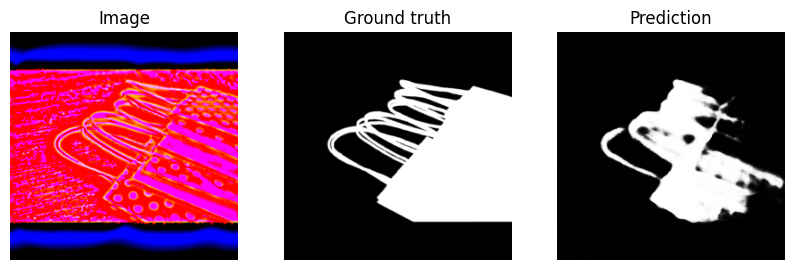

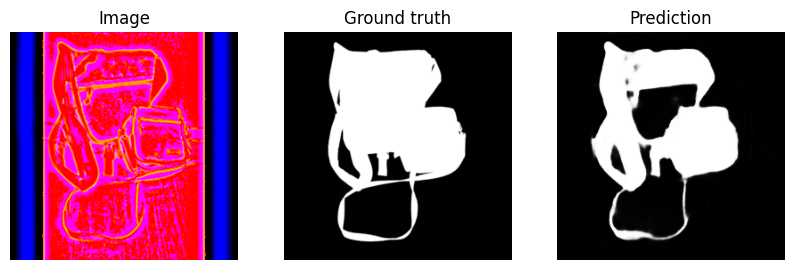

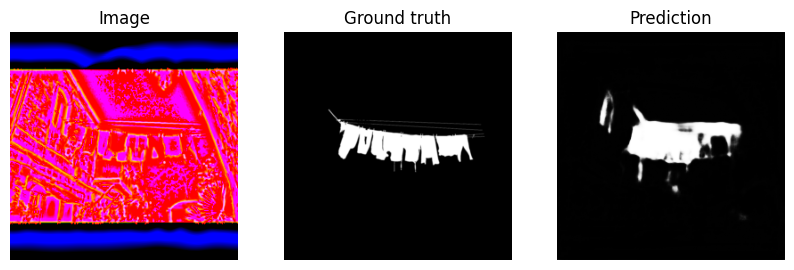

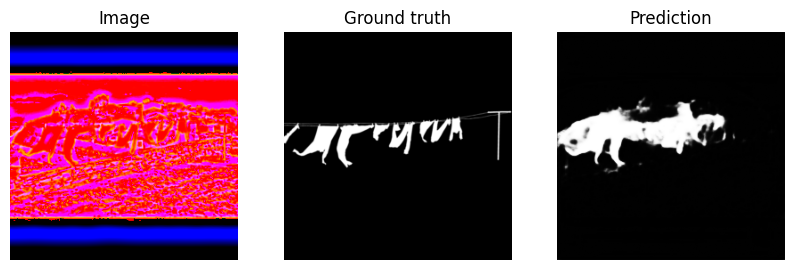

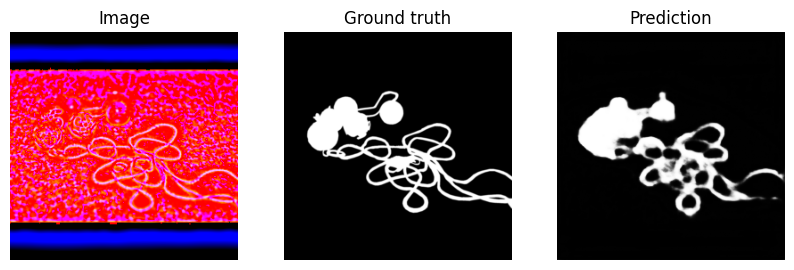

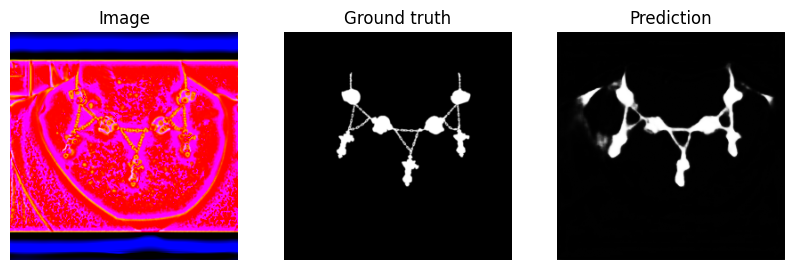

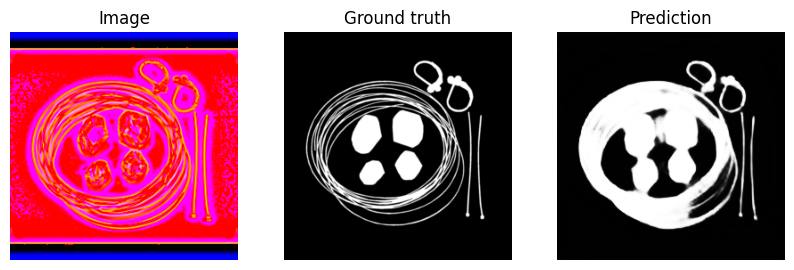

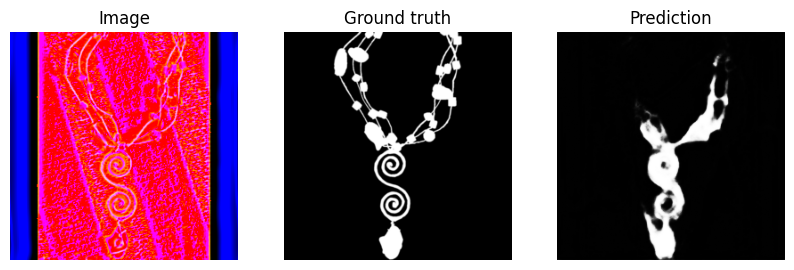

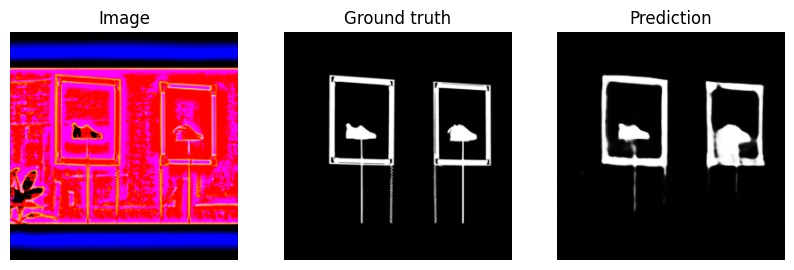

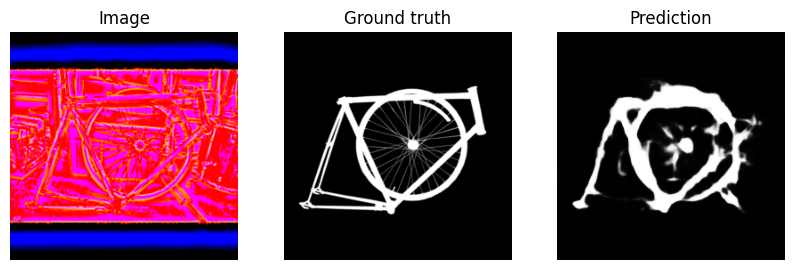

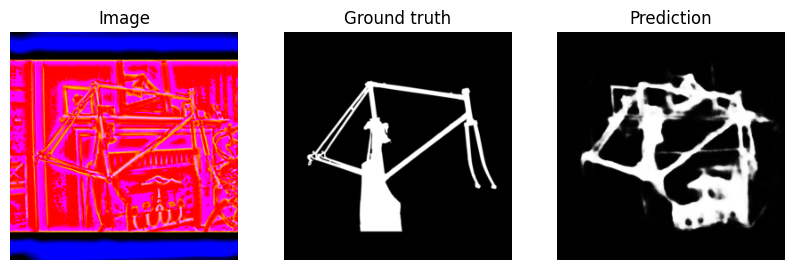

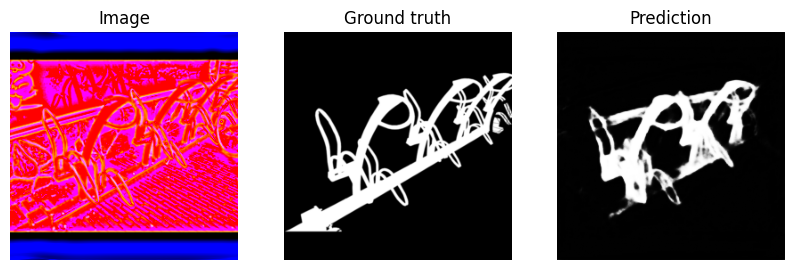

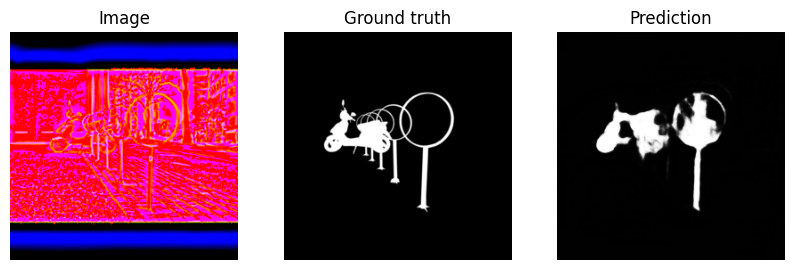

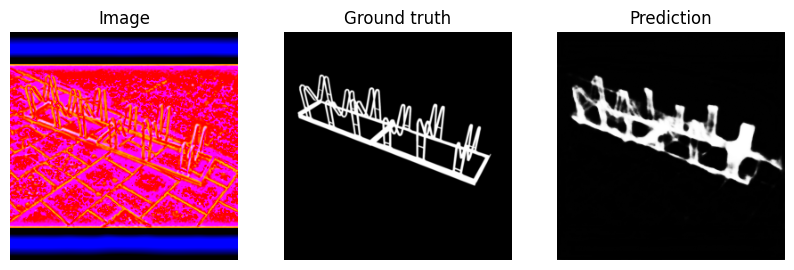

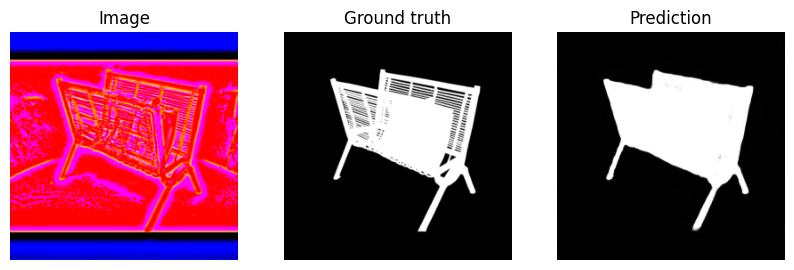

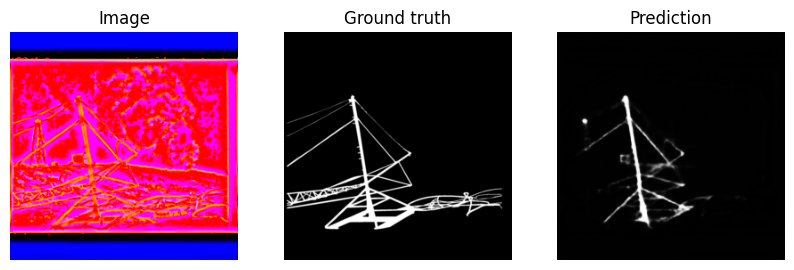

In [ ]:
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 40:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze(), cmap='gray')
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
